In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

In [51]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip'
df = pd.read_csv(url, sep = ';', parse_dates={'datetime': ['Date','Time']}, infer_datetime_format = True, low_memory = False, na_values = ['nan','?'])

C:\Users\MSI 1\AppData\Local\Temp\ipykernel_5556\4133175463.py:2: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(url, sep = ';', parse_dates={'datetime': ['Date','Time']}, infer_datetime_format = True, low_memory = False, na_values = ['nan','?'])
C:\Users\MSI 1\AppData\Local\Temp\ipykernel_5556\4133175463.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(url, sep = ';', parse_dates={'datetime': ['Date','Time']}, infer_datetime_format = True, low_memory = False, na_values = ['nan','?'])
C:\Users\MSI 1\AppData\Local\Temp\ipykernel_5556\4133175463.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst

KeyboardInterrupt: 

In [52]:
print(df.head())
print(df.info())
print(df.describe())

             datetime  Global_active_power  Global_reactive_power  Voltage  \
0 2006-12-16 17:24:00                4.216                  0.418   234.84   
1 2006-12-16 17:25:00                5.360                  0.436   233.63   
2 2006-12-16 17:26:00                5.374                  0.498   233.29   
3 2006-12-16 17:27:00                5.388                  0.502   233.74   
4 2006-12-16 17:28:00                3.666                  0.528   235.68   

   Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
0              18.4             0.0             1.0            17.0   
1              23.0             0.0             1.0            16.0   
2              23.0             0.0             2.0            17.0   
3              23.0             0.0             1.0            17.0   
4              15.8             0.0             1.0            17.0   

   Global_active_power_scale  Global_active_power_scaled  
0                   0.374796                 

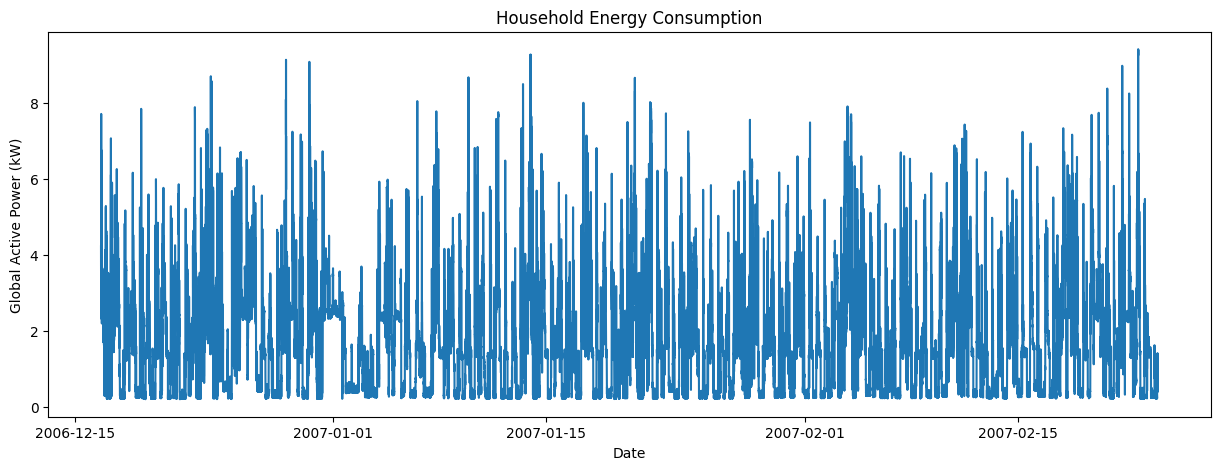

In [53]:
plt.figure(figsize=(15, 5))
plt.plot(df['datetime'][:100000], df['Global_active_power'][:100000])
plt.xlabel('Date')
plt.ylabel('Global Active Power (kW)')
plt.title('Household Energy Consumption')
plt.show()

In [54]:
df.dropna(inplace=True)

scaler = MinMaxScaler()
df['Global_active_power_scaled'] = scaler.fit_transform(df[['Global_active_power']])

In [55]:
def create_seq(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)- seq_length):
        xs.append(data[i:i+seq_length])
        ys.append(data[i+seq_length])

    return np.array(xs), np.array(ys)

In [56]:
seq_length = 24
X, y = create_seq(df['Global_active_power_scaled'].values, seq_length)
X = X.reshape((X.shape[0], X.shape[1], 1))

In [57]:
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size+val_size]
y_val = y[train_size:train_size+val_size]

X_test = X[train_size+val_size:]
y_test = y[train_size+val_size:]

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (1434479, 24, 1), Val: (307388, 24, 1), Test: (307389, 24, 1)


In [58]:
class LSTMModel(nn.Module):
    def __init__(self, input_size = 1, hidden_size = 50, num_layers = 1, output_size = 1):
        super(LSTMModel, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size,hidden_size,num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size,output_size)

    def forward(self,x):
        h0 = torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(x.device)

        out, _ = self.lstm(x,(h0,c0))

        out = out[:, -1, :]

        out = self.fc(out)

        return out

In [59]:
model = LSTMModel()
print(model)

LSTMModel(
  (lstm): LSTM(1, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)


In [60]:
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)

X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val)

X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

In [61]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor,y_val_tensor)

batch_Size = 64
lr = 0.01

train_loader = DataLoader(train_dataset, batch_Size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_Size, shuffle=False)

In [62]:
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")

Number of training batches: 22414
Number of validation batches: 4803


In [63]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr)

print(f"Model has {sum(p.numel() for p in model.parameters())} parameters")

Model has 10651 parameters


In [64]:
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0

    for X_batch, y_batch in dataloader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        predictions = model(X_batch)
        loss = criterion(predictions.squeeze(), y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = loss/len(dataloader)
    return avg_loss

def val_model(model,dataloader,criterion,device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            predictions = model(X_batch)
            loss = criterion(predictions.squeeze(), y_batch)

            total_loss += loss.item()

    avg_loss = total_loss/len(dataloader)
    return avg_loss

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

num_epochs = 20
train_losses = []
val_losses = []

print("Starting Training")
for epoch in range(num_epochs):

    train_loss = train_model(model,train_loader,criterion,optimizer,device)
    train_losses.append(train_loss)

    val_loss = val_model(model,val_loader,criterion,device)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

print("Training complete!")

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training Progress')
plt.legend()
plt.grid(True)
plt.show()